# Lab 3 - Machine Learning

| Authors |
|---------|
| Austin Milne |
| Jude Bennett |
| William Ancich |

## IR Distance Sensor Profiling
Four sensors were used. Two short range sensors (4cm-30cm) and two long range sensors (20cm-150cm). Each pair of sensors (short + short & long + long) were measured at 6 distances that are relevant to their range. Based on Lab 1, the sensor are profiled against the function:

$$
D = \frac{a}{V} + b \\~\\
\begin{aligned}
    D & = \text{Distance} \\
    V & = \text{Voltage} \\
    a, \, b & = \text{Constants} \\
\end{aligned}
$$

In [181]:
# Necessary Libraries
import json
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mergedeep import merge
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pathlib
import statistics

# Read Raw Data
with open(r"data/data.json") as f:
    data = json.load(f)

## Check Voltages
Plot the voltages to visually inspect that the sensors are behaving as expected.

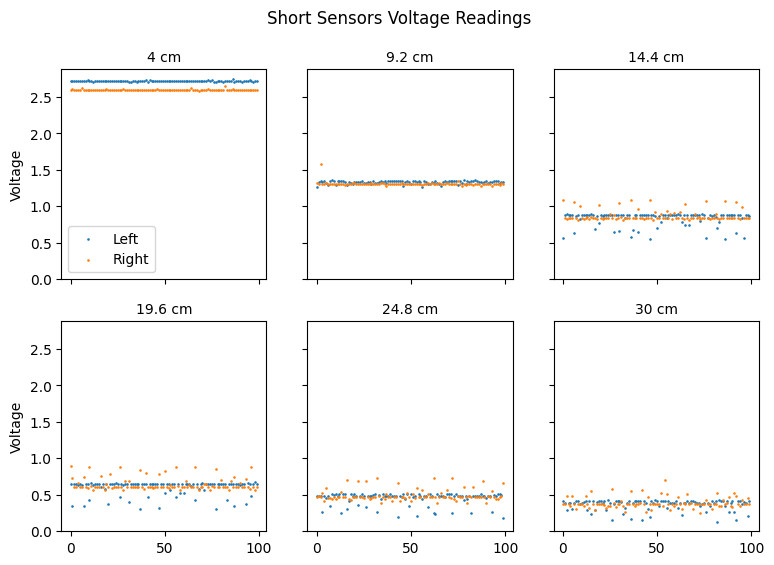

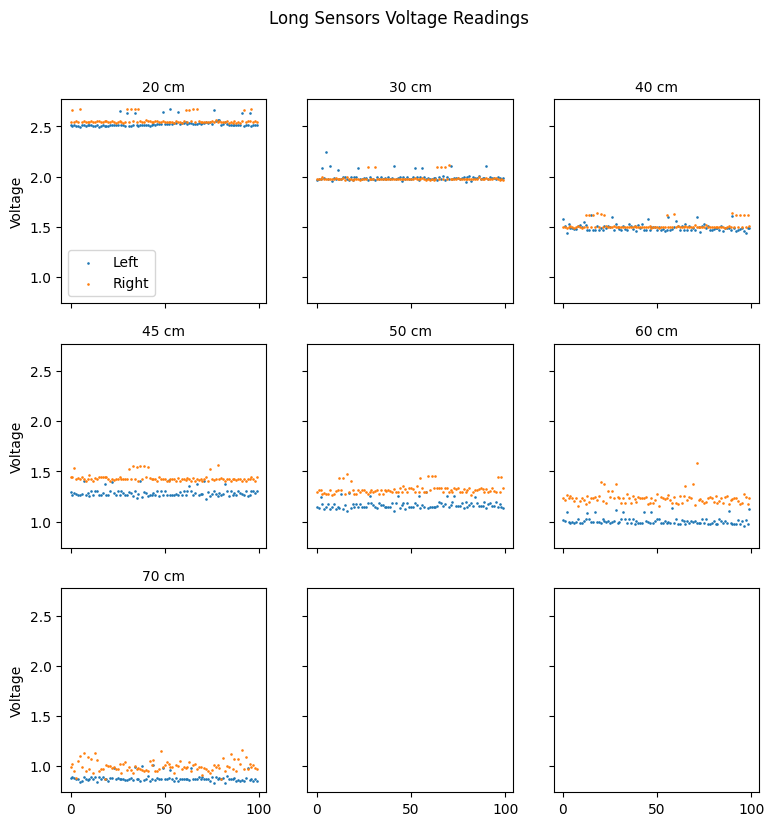

In [182]:
# Plot the voltage readings for each distance
def plot_voltages(data, name):
    distances = list(data.keys())
    distances.sort(key=lambda x: float(x))
    count=len(distances)
    columns = 3
    rows = math.ceil((count - count%3)/3)
    rows = rows+1 if count%3 else rows
    fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(3*columns, 3*rows))
    fig.suptitle(f'{name} Voltage Readings')
    for i, distance in enumerate(distances):
        # Create dataframe with each sensor's data
        df = pd.DataFrame({
            "Time": np.arange(start=0, stop=len(data[distance]["data"][0])*(1/20), step=(1/20)),
            "Left": data[distance]["data"][0],
            "Right": data[distance]["data"][1]
        })
        # Plot each sensor's data
        # sub = axs[(i-(i%3))/3, i%3]
        sub = axs[int((i-(i%3))/3), i%3]
        for sensor in ["Left", "Right"]:
            sub.scatter(df.index, df[sensor], label=sensor, s=0.75)
        sub.set_title(f"{distance} cm", fontsize=10)
        if (i%3 == 0): sub.set_ylabel("Voltage")
        if (i==0): sub.legend()
    plt.show()
    fig.savefig(f"out/plots/{name} Voltage Readings.png")

# Plot voltages for short and long sensors
dcs = data["Calibrations"]["Short"]
dcl = data["Calibrations"]["Long"]

plot_voltages(dcs, "Short Sensors")
plot_voltages(dcl, "Long Sensors")

## Sensor Calibration
Determine the relevant constants for each sensor to fit the inverse relationship between voltage and distance.

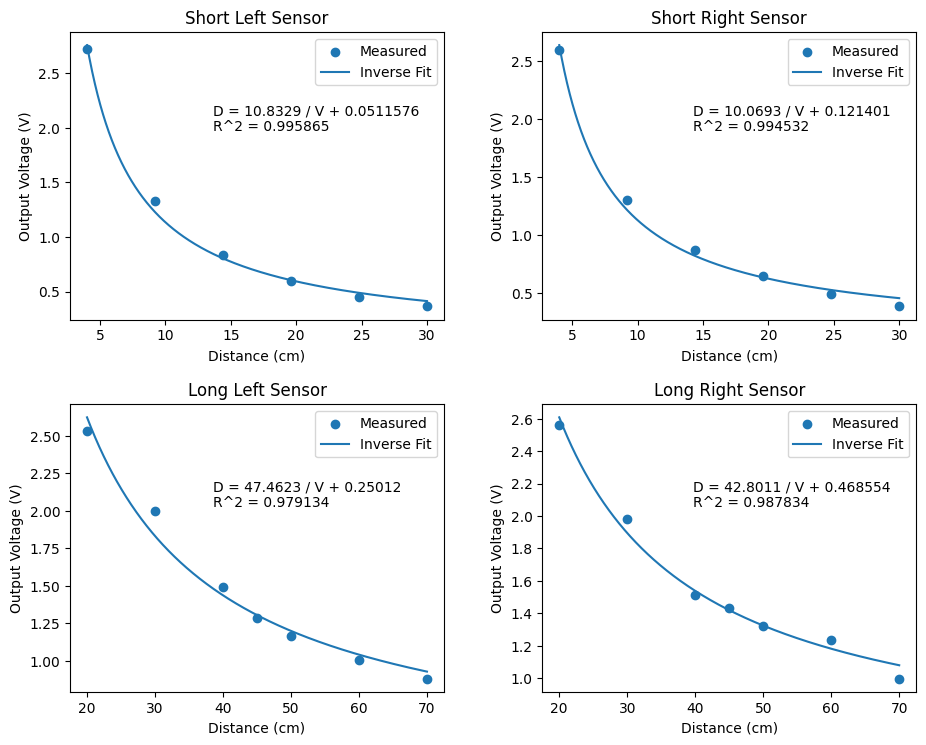

Sensor Properties
     Sensor                    Function      R^2
 Short Left D = 10.8329 / V + 0.0511576 0.995865
Short Right  D = 10.0693 / V + 0.121401 0.994532
  Long Left   D = 47.4623 / V + 0.25012 0.979134
 Long Right  D = 42.8011 / V + 0.468554 0.987834


In [183]:
# Run regression on range of functions for each sensor
sensors = ["Left", "Right"]
sets = ["Short", "Long"]
dc = data["Calibrations"]
sensor_params = {}
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=4.0)
for i, set in enumerate(sets):
    for j, sensor in enumerate(sensors):
        readings = pd.DataFrame({
            "Distance": [float(dist) for dist in dc[set].keys()],
            "Voltage": [np.mean(dc[set][dist]["data"][j]) for dist in dc[set]]
        })
        readings.sort_values(by="Distance", inplace=True)
        readings.reset_index(drop=True, inplace=True)
        
        # Inverse Regression
        inverse = lambda x, a, b : a/x + b
        inv_a, inv_b = curve_fit(inverse, readings["Distance"], readings["Voltage"])[0]
        inv_r2 = r2_score(readings["Voltage"], inverse(np.asarray(readings["Distance"]), inv_a, inv_b))
        merge(sensor_params, {
            set: {
                sensor: {
                    "a": inv_a,
                    "b": inv_b,
                    "r2": inv_r2,                    
                }
            }
        })
                
        # Plot the sensor data and regressions lines
        pts = np.linspace(min(readings["Distance"]), max(readings["Distance"]), 1000)
        sub = axs[i, j]
        sub.scatter(readings["Distance"], readings["Voltage"], label="Measured")
        sub.plot(pts, inverse(np.asarray(pts), inv_a, inv_b), label=f"Inverse Fit")
        sub.set_title(f"{set} {sensor} Sensor")
        sub.set_xlabel("Distance (cm)")
        sub.set_ylabel("Output Voltage (V)")
        sub.text(0.23 + j*0.48, 0.8 - i*0.47, f"D = {inv_a:3.6} / V + {inv_b:3.6}\nR^2 = {inv_r2:3.6}", fontsize=10, transform=plt.gcf().transFigure)
        sub.legend()
    
pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
plt.savefig(f"out/plots/Sensor_Fits.png")
plt.show()

# Print Sensor Properties Formula in pretty table
print("Sensor Properties")
functions = []
for set in sensor_params:
    for sensor in sensor_params[set]:
        functions.append({
            "Sensor": f"{set} {sensor}",
            "Function": f"D = {sensor_params[set][sensor]['a']:3.6} / V + {sensor_params[set][sensor]['b']:3.6}",
            "R^2": sensor_params[set][sensor]['r2']
        })
functions = pd.DataFrame(functions)
print(functions.to_string(index=False))

